#  MVP de Machine Learning - Parte (a)

## Prof. Tatiana Escovedo
## Aluna: Cecília Corrêa Ferrari Rey
### MVP Estudo de BTC (Data: julho/2023)

##1.Definição do Problema

O objetivo deste trabalho é desenvolver um modelo de machine learning utilizando técnicas de regressão para prever a probabilidade de uma rentabilidade de retorno positivo do ativo **BTC**, em relação a quantidades de dias que se faz o hodl do ativo, ou seja, a probabilidade de retorno positiva em função de quanto tempo o investidor manteve o investimento.

A base de dados original apresenta a cotação diária do ativo BTC.  O arquivo usado neste estudo possui 235 linhas, e foi rodado um código que simulou a aquisição do ativo em todas as datas presentes na base de dados considerando um período de hodl do ativo em carteira, que varia de um dia até 235 dias, tanto é que a planilha gerada com essa lógica possui 27.495 linhas. A partir disso possuímos retornos positivos e negativos que são convertidos para valores binários, retornos positivos são iguais a 1, valores negativos são iguais a 0.

Caso o investidor mantenha o investimento por 30 dias a probabilidade de retorno positivo é de 45%, já se ele manter por 1.000 dias a probabilidade de retorno positivo é de 98%.

**Informação sobre os atributos:**

1.   **BTC**: criptomoeda Bitcoin USD (símbolo "BTC _USD");
2.   **ETH**: criptomoeda Ethereum USD (símbolo "ETH _USD"); e
3.   **MATIC**: criptomoeda MATIC (é um token de utilidade).


###1.1.Importação das Bibliotecas

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários neste notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.formula.api as smf
import statsmodels.api as sm # biblioteca de modelagem estatística

###1.2.Carga do Dataset

In [ ]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/CECILIACFR/DATASCIENCE/main/dados_historicos_resumidos.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,BTC,ETH,MATIC
0,21974.67,1509.30,0.82
1,20708.83,1368.64,0.73
2,21453.58,1492.36,0.81
3,23085.18,1650.71,0.88
4,24015.95,1724.15,0.95


A seguir serão excluídas as colunas ['ETH'] e ['MATIC'] do dataset e restará somente a coluna ['BTC'] do estudo em questão.

In [ ]:
del dataset['ETH']
del dataset['MATIC']

dataset

,BTC
0,21974.67
1,20708.83
2,21453.58
3,23085.18
4,24015.95
...,...
230,24709.10
231,24910.83
232,26290.41
233,27585.39


In [ ]:
linhas_base=dataset.shape[0]
print(linhas_base)

235


In [ ]:
# Verifique existência de valores ausentes
print(dataset.isnull().sum())

BTC    0
dtype: int64


In [ ]:
# criar uma lista vazia para armazenar os resultados para cada valor de 'numero'
resultados = []

# iterar através dos números de 1 a 235
for numero in range(1, linhas_base):
    # criar uma cópia da base de dados original
    base_um = dataset.copy()

    # calcular a rentabilidade com base no valor de 'numero'
    base_um['rent'] = (base_um['BTC'] - base_um['BTC'].shift(numero)) / base_um['BTC'].shift(numero)

    # remover as linhas que contêm valores ausentes
    base_um = base_um.dropna()

    # calcular se houve lucro ou prejuízo e armazenar o resultado em uma nova coluna
    base_um['lucro_prejuizo_'] = base_um['rent'].apply(lambda x: 0 if x < 0 else 1)

    # definir o valor de 'numero' e excluir as colunas desnecessárias
    base_um['tempo'] = numero
    del base_um['BTC']
    del base_um['rent']

    # renomear a coluna 'lucro_prejuizo_' para 'lucro_prejuizo'
    base_um['lucro_prejuizo'] = base_um['lucro_prejuizo_']
    del base_um['lucro_prejuizo_']

    # adicionar os resultados à lista de resultados
    resultados.append(base_um)

# concatenar os resultados em um único dataframe
resultado_final = pd.concat(resultados)
dataset=resultado_final
dataset

,tempo,lucro_prejuizo
1,1,0
2,1,1
3,1,1
4,1,1
5,1,1
...,...,...
233,232,1
234,232,1
233,233,1
234,233,1


In [ ]:
# In[ ]: Tabela de frequências absolutas da variável 'Acidente'
dataset['lucro_prejuizo'].value_counts()

1    14041
0    13454
Name: lucro_prejuizo, dtype: int64

In [ ]:
#Características das variáveis do dataset
dataset.info()

#Estatísticas univariadas
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27495 entries, 1 to 234
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tempo           27495 non-null  int64
 1   lucro_prejuizo  27495 non-null  int64
dtypes: int64(2)
memory usage: 644.4 KB


,tempo,lucro_prejuizo
count,27495.000000,27495.000000
mean,78.666667,0.510675
std,55.272054,0.499895
min,1.000000,0.000000
25%,32.000000,0.000000
50%,69.000000,1.000000
75%,118.000000,1.000000
max,234.000000,1.000000


##2.Preparação de dados

O conjunto de dados disponíveis possui apenas duas colunas, sendo a segunda coluna referente à variável alvo que desejamos prever, denominada "**lucro_prejuizo**". Nesse contexto, não é necessário realizar o processo de seleção de atributos, conhecido como "feature selection", com o objetivo de reduzir a dimensionalidade do conjunto de dados. Essa redução facilitaria a execução do modelo e ajudaria a evitar problemas de **overfitting**. A única coluna restante, denominada "**tempo**", contém as informações necessárias para realizar a previsão. Portanto, não é possível reduzir o número de variáveis de entrada do modelo.


In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

###2.1.Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
# Separação em conjuntos de treino e teste (holdout)
array = dataset.values

X = array[:,0:1]
y = array[:,1]

print(X)
print(y)

[[  1]
 [  1]
 [  1]
 ...
 [233]
 [233]
 [234]]
[0 1 1 ... 1 1 1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

##3.Modelagem e Inferência

Iniciaremos agora a etapa de modelagem e inferência, mas não sabemos de antemão quais algoritmos performarão bem nesse **conjunto de dados de treino**.  Assim, usaremos a validação cruzada para treinar e avaliar os modelos usando a métrica acurácia.
Primeiramente, iremos avaliar os algoritmos com a configuração padrão de hiperparâmetros da scikit-Learn.

###3.1.Criação e avaliação de modelos: linha base

In [ ]:
np.random.seed(seed) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))


In [ ]:
# Listas para armazenar os resultados
results = []
names = []

In [ ]:
# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.535142 (0.008096)
KNN: 0.521958 (0.009261)
CART: 0.547009 (0.007970)
NB: 0.561238 (0.008060)
SVM: 0.561557 (0.008641)
Bagging: 0.545918 (0.008786)
RF: 0.546873 (0.008712)
ET: 0.547009 (0.007970)
Ada: 0.560102 (0.009469)
GB: 0.558056 (0.007799)
Voting: 0.557283 (0.008099)


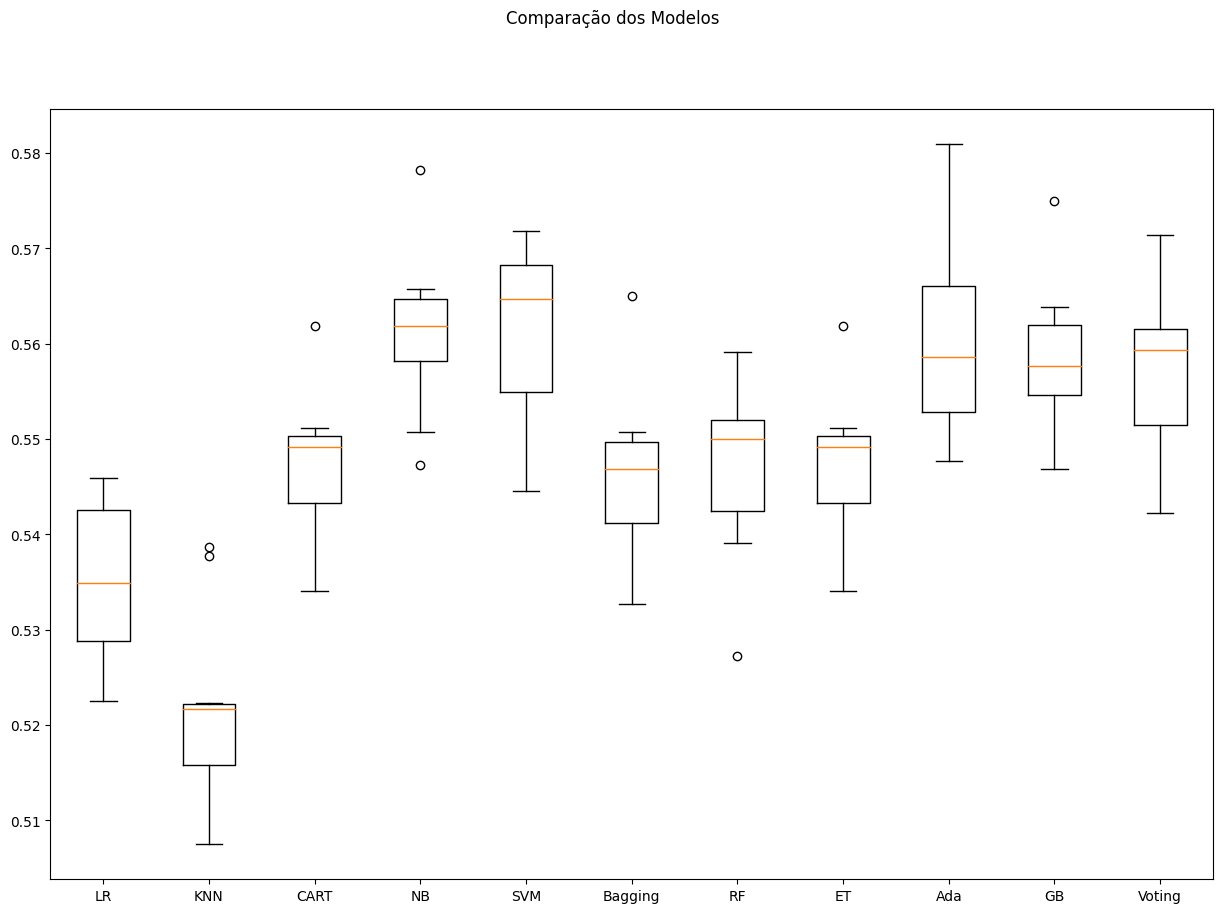

In [ ]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Com base nos resultados de desempenho dos algoritmos de machine learning apresentados, podemos justificar a escolha dos algoritmos mais indicados da seguinte maneira:

**Naive Bayes (NB)**: Com uma acurácia de 0.561238 e um desvio padrão de 0.008060, o algoritmo Naive Bayes demonstrou um bom desempenho médio e uma variância relativamente baixa. Isso sugere que o NB é um bom candidato para a tarefa de modelagem em questão.

**Support Vector Machine (SVM)**: Com uma acurácia próxima à do Naive Bayes, 0.561557, e um desvio padrão de 0.008641, o SVM também apresentou um desempenho sólido. Embora tenha uma variância ligeiramente maior, ainda está na faixa aceitável.

**Gradient Boosting (GB)**: Com uma acurácia de 0.558056 e um desvio padrão de 0.007799, o algoritmo Gradient Boosting também demonstrou bom desempenho médio e baixa variância. Portanto, é uma escolha promissora para a modelagem.

Esses três algoritmos (**Naive Bayes, Support Vector Machine e Gradient Boosting**) se destacam em relação aos demais com base em seus resultados de desempenho.

Os resultados de desempenho apresentados indicam que esses três algoritmos tiveram um desempenho sólido e uma variância relativamente baixa, e não é possível afirmar definitivamente se houve **underfitting**.

###3.2.Criação e avaliação de modelos: dados padronizados e normalizados

Em seguida, vamos repetir esse processo, utilizando a biblioteca **Pipeline** para criar e avaliar os modelos através da validação cruzada com os dados padronizados e normalizados (evitando o *data leakage*) e comparar o seu resultado com os modelos treinados com o dataset original.

LR-orig: 0.535 (0.008)
KNN-orig: 0.522 (0.009)
CART-orig: 0.547 (0.008)
NB-orig: 0.561 (0.008)
SVM-orig: 0.562 (0.009)
Bag-orig: 0.546 (0.009)
RF-orig: 0.547 (0.009)
ET-orig: 0.547 (0.008)
Ada-orig: 0.560 (0.009)
GB-orig: 0.558 (0.008)
Vot-orig: 0.557 (0.008)
LR-padr: 0.535 (0.008)
KNN-padr: 0.522 (0.009)
CART-padr: 0.547 (0.008)
NB-padr: 0.561 (0.008)
SVM-padr: 0.562 (0.009)
Bag-padr: 0.547 (0.008)
RF-padr: 0.546 (0.008)
ET-padr: 0.547 (0.008)
Ada-padr: 0.560 (0.009)
GB-padr: 0.558 (0.008)
Vot-padr: 0.557 (0.008)
LR-norm: 0.535 (0.008)
KNN-norm: 0.522 (0.009)
CART-norm: 0.547 (0.008)
NB-norm: 0.561 (0.008)
SVM-norm: 0.562 (0.009)
Bag-norm: 0.546 (0.010)
RF-norm: 0.547 (0.010)
ET-norm: 0.547 (0.008)
Ada-norm: 0.560 (0.009)
GB-norm: 0.558 (0.008)
Vot-norm: 0.557 (0.008)


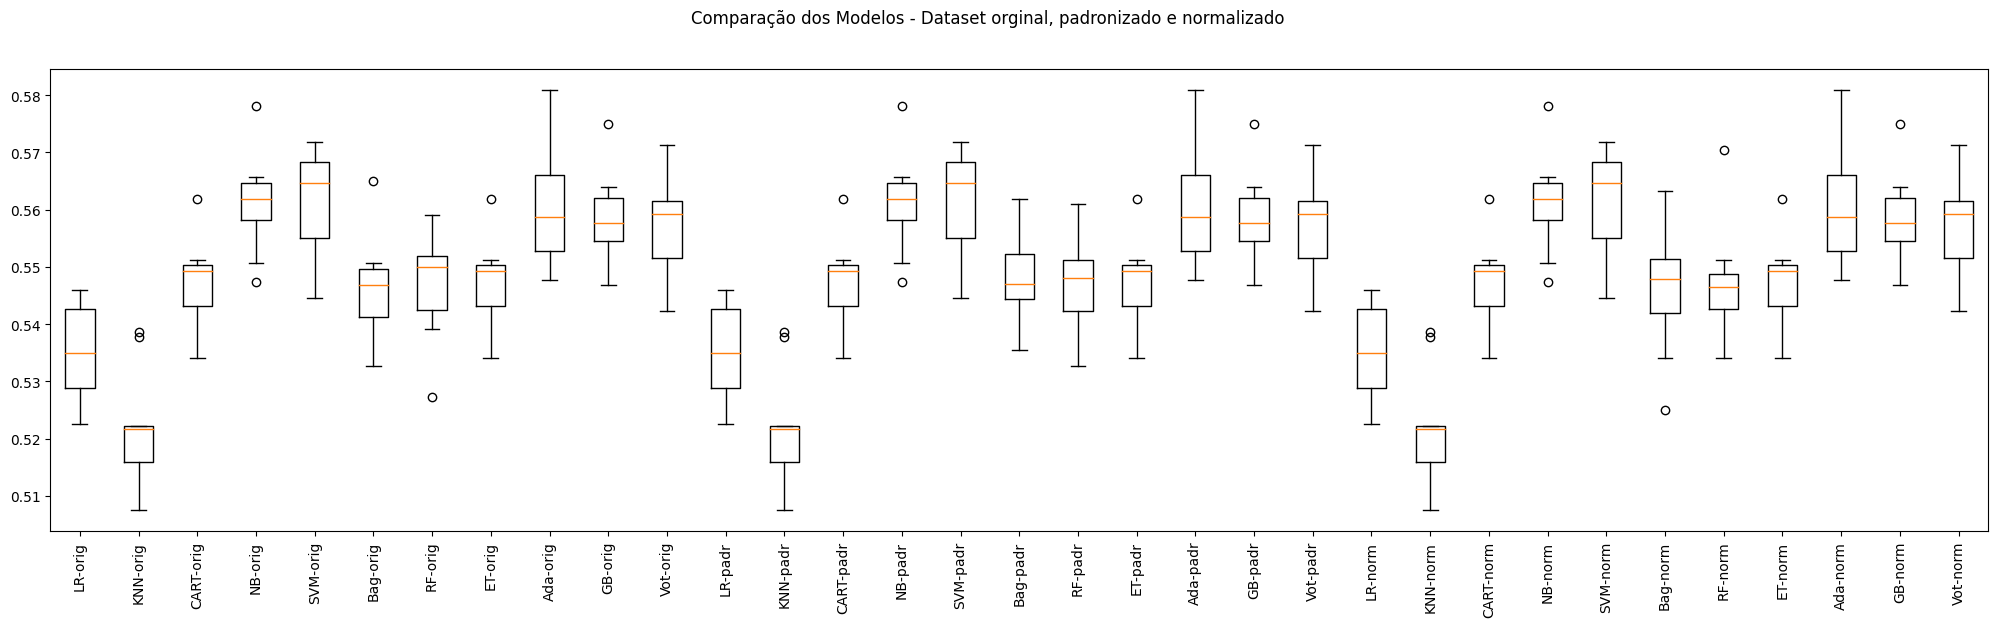

In [ ]:
np.random.seed(seed) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()



Com base nos resultados de desempenho dos algoritmos de machine learning fornecidos, podemos observar que vários algoritmos têm um desempenho semelhante, com acurácias próximas e desvios padrão relativamente baixos. Os algoritmos **Naive Bayes (NB), Support Vector Machine (SVM), Decision Tree (CART), Gradient Boosting (GB) e Voting (Vot)** são consistentemente competitivos em todas as três versões dos dados (**orig, padr, norm**), com acurácias em torno de **0.55-0.56**.

Com base exclusivamente nos resultados apresentados, os algoritmos **Naive Bayes (NB), Support Vector Machine (SVM) e Gradient Boosting (GB)** parecem ser as opções mais indicadas, pois apresentam desempenho consistente e acurácias ligeiramente mais altas em comparação com os demais algoritmos.

###3.3.Otimização dos hiperparâmetros

Vamos agora utilizar a função **RandomizedSearchCV** para otimizar os hiperparâmetros do algoritmo **Naive Bayes (NB)**, visando obter resultados ainda melhores. Vale ressaltar que, entre todos os modelos, a **Support Vector Machine (SVM)** alcançou a maior acurácia. No entanto, devido à sua lentidão, optamos por **Naive Bayes (NB)**, que apresentou a segunda melhor acurácia, porém com um tempo de execução significativamente menor.

In [ ]:
# Tuning do NB
np.random.seed(seed)  # Definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
nb = ('NB', GaussianNB())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('NB-orig', Pipeline(steps=[nb])))
pipelines.append(('NB-padr', Pipeline(steps=[standard_scaler, nb])))
pipelines.append(('NB-norm', Pipeline(steps=[min_max_scaler, nb])))

param_grid = {
    'NB__var_smoothing': np.logspace(-9, 0, num=10)  # Exemplo de hiperparâmetro a ser otimizado
}

# Prepara e executa o RandomizedSearchCV
for name, model in pipelines:
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=scoring, cv=kfold)
    random_search.fit(X_train, y_train)
    # Imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, random_search.best_score_, random_search.best_params_))

Sem tratamento de missings: NB-orig - Melhor: 0.561238 usando {'NB__var_smoothing': 1e-09}
Sem tratamento de missings: NB-padr - Melhor: 0.561238 usando {'NB__var_smoothing': 1e-09}
Sem tratamento de missings: NB-norm - Melhor: 0.561238 usando {'NB__var_smoothing': 1e-09}


##4.Finalização do Modelo

Podemos agora finalizar o modelo escolhido. O modelo que alcançou os melhores resultados e foi o escolhido para implementação foi o **Naive Bayes (NB)** com os dados pradronizados.

A seguir, finalizaremos esse modelo, treinando-o em todo o conjunto de dados de treinamento (sem validação cruzada), e faremos predições para o conjunto de dados de teste que foi separado logo no início da prática, a fim de confirmarmos os resultados. Primeiro, iremos realizar a padronização dos dados de entrada. Depois, treinaremos o modelo e exibiremos a acurácia de teste.

In [ ]:
# Avaliação do modelo com o conjunto de teste

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = GaussianNB()
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(f'Acurácia: {accuracy_score(y_test, predictions)}','\n')

from sklearn.metrics import classification_report
predicions = model
print(classification_report(y_test,predictions))

print(f'Acurácia: {accuracy_score(y_test, predictions):.2f}')
print(f'Precisão: {precision_score(y_test, predictions):.2f}')
print(f'Recall: {recall_score(y_test, predictions):.2f}')
print(f'F-score: {f1_score(y_test, predictions):.2f}')


Acurácia: 0.5562829605382796 

              precision    recall  f1-score   support

           0       0.53      0.71      0.61      2691
           1       0.60      0.40      0.48      2808

    accuracy                           0.56      5499
   macro avg       0.57      0.56      0.55      5499
weighted avg       0.57      0.56      0.55      5499

Acurácia: 0.56
Precisão: 0.60
Recall: 0.40
F-score: 0.48


O desempenho do modelo no **conjunto de teste** foi de **55,63%**, enquanto o modelo **Naive Bayes (NB)** anterior alcançou uma acurácia média de **56,12%** no **conjunto de treinamento**. Embora o novo modelo não tenha superado a acurácia do modelo anterior, a diferença entre os dois resultados é relativamente pequena.
Quando o modelo estiver em produção e lidando com dados não parece sugerir que o modelo está mantendo um desempenho consistente. No entanto, isso pode indicar que o modelo **não está sofrendo de overfitting significativo**, pois está lidando de maneira satisfatória com os dados não vistos.



Vamos agora preparar o modelo para utlização em produção. Para isso, vamos treiná-lo como TODO dataset, e não apenas com o conjunto de treino.

In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

GaussianNB()

A seguir apresento análise que tem como fim calcular a probabilidade de retorno positivo, em relação a quantidades de dias que você faz o hodl do ativo, ou seja, a probabilidade de retorno positiva em função de quanto tempo o investidor manteve o investimento.

Caso o investidor mantenha o investimento por 30 dias a probabilidade de retorno positivo é de 45%, já se ele manter por 1.000 dias a probabilidade de retorno positivo é de 98%. Abaixo um gráfico que exemplifica esses resultados.

In [ ]:
modelo= smf.glm(formula='lucro_prejuizo ~ tempo', data=dataset, family=sm.families.Binomial()).fit()

# Parâmetros do modelo
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         lucro_prejuizo   No. Observations:                27495
Model:                            GLM   Df Residuals:                    27493
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18864.
Date:                Tue, 18 Jul 2023   Deviance:                       37728.
Time:                        13:13:20   Pearson chi2:                 2.75e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01358
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2921      0.021    -13.805      0.000      -0.334      -0.251
tempo          0.0043      0.000     19.222      0.000       0.004       0.005
==============================================================================
"""

In [ ]:
#Calculando a probabilidade manualmente
g=-(-0.2921+0.0043*30)
p = (1/(1+2.71**g))
print(p)

0.459438748375338


In [ ]:
#Questão: qual a probabilidade media de um investidor obter um retorno possitivo sabendo que ele fara hodl de BTC por 30 dias?

modelo.predict(pd.DataFrame({'tempo':[30]}))

0    0.4591
dtype: float64

In [ ]:
#Questão: qual a probabilidade media de um investidor obter um retorno possitivo sabendo que ele fara hodl de BTC por 1000 dias?

modelo.predict(pd.DataFrame({'tempo':[1000]}))

0    0.981643
dtype: float64

In [ ]:
linhas_base=1001

# criar um dataframe com as previsões
previsoes = pd.DataFrame()

# iterar sobre os números de previsão de 1 a 1001
for numero_previsao in range(1, linhas_base):
    # prever o lucro ou prejuízo para o tempo especificado
    resultado = modelo.predict(pd.DataFrame({'tempo': [numero_previsao]}))
    # adicionar o resultado ao dataframe de previsões
    previsoes = previsoes.append(pd.DataFrame({'tempo': [numero_previsao], 'lucro_prejuizo': resultado}))

# imprimir o dataframe de previsões
print(previsoes)

    tempo  lucro_prejuizo
0       1        0.428534
0       2        0.429581
0       3        0.430628
0       4        0.431675
0       5        0.432723
..    ...             ...
0     996        0.981332
0     997        0.981410
0     998        0.981488
0     999        0.981565
0    1000        0.981643

[1000 rows x 2 columns]


In [ ]:
previsoes['lucro']=previsoes['lucro_prejuizo']
previsoes['tempo_dias']=previsoes['tempo']
del previsoes['lucro_prejuizo']
del previsoes['tempo']

previsoes

,lucro,tempo_dias
0,0.428534,1
0,0.429581,2
0,0.430628,3
0,0.431675,4
0,0.432723,5
...,...,...
0,0.981332,996
0,0.981410,997
0,0.981488,998
0,0.981565,999


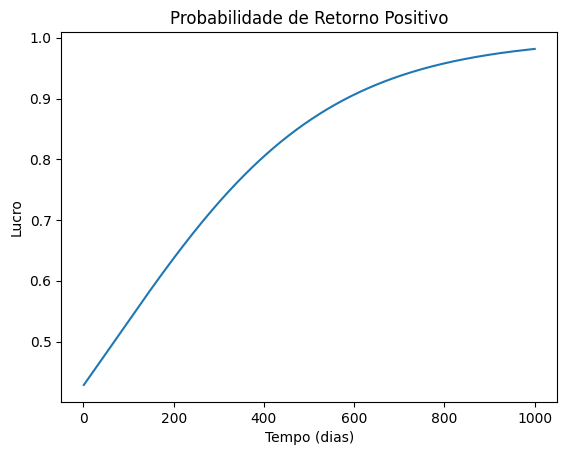

In [ ]:
# Podemos observar que quanto mais tempo o investidor segura o ativo, maior a probabilidade de retorno positivo.

# plotar o gráfico de linha
plt.plot(previsoes['tempo_dias'], previsoes['lucro'])

# adicionar rótulos aos eixos x e y
plt.xlabel('Tempo (dias)')
plt.ylabel('Lucro')
plt.title('Probabilidade de Retorno Positivo')

# exibir o gráfico
plt.show()


A partir do gráfico acima podemos concluir que **quanto mais tempo o investidor mantêm o investimento maior é a probabilidade de retorno positivo**.

##5.Conclusão Final

Foi possível realizar a análise de diversos métodos de aprendizado de máquina, levando em consideração as questões de regressão, com o objetivo de identificar o estimador mais apropriado em diferentes cenários (original, padrão, normalizado). Além disso, foi viável determinar os parâmetros ajustáveis ​​mais eficientes para prever o valor desejado, alcançando a maior acurácia e precisão possível. Com base nesses resultados, podemos concluir que encontramos o modelo mais eficaz para lidar com o problema apresentado.